# Entrega 2 - Árboles de decisión

### Grupo 10:
     - T. Rischewski  C.I. 4.923.024-2
     - J. P. Filevich C.I. 5.002.310-5
     - J. Ferrand C.I. 4.819.108-1



## 1. Objetivo

El objetivo de esta tarea es construir dos clasificadores utilizando los algoritmos ID3 y Random Forest. Se utilizará un subconjunto de los datos QSAR para entrenar y otro subconjunto para evaluar los algoritmos. 
 El modelo QSAR contiene 1024 atributos (molecular fingerprints) que describen combinaciones de moléculas que resultan muy tóxica representada con el valor positivo y combinaciones que no resultan tan tóxicas representada con el valor negativo. De las tóxicas se encuentran 741 combinaciones y 8251 que no son tan tóxicas. Se puede observar que las clases están muy desbalanceadas, hay muchos más clasificados como negativos que como positivos.
El éxito del aprendizaje se evaluará basado en cuánto de los casos positivo y negativos logra identificar dentro del set de evaluación, utilizando las medidas de accuracy, precisión,  recuperación y medida-F. Luego se comparan los resultados obtenidos con los de las implementaciones de Scikit-learn para esos algoritmos sobre QSAR. 



## 2. Diseño

En el momento de implementar el clasificadores ID3 se optó por  mantenerse lo más cercano al algoritmo que se puede encontrar en el libro Machine Learning de Tom M. Mitchell, el cual fue presentado en clase de aprendizaje automático. Para el Random Forest se utilizó el algoritmo ID3 para generar los árboles que formarán parte del grupo de decisión, tomando para cada uno de los árboles una muestra aleatoria de datos QSAR con repetición, y se seleccionan atributos al azar para utilizar.

## 2.1 Preprocesamiento de datos

Se utilizaron los datos QSAR originales, manteniendo la cantidad de atributos, los valores que toman y la evaluación de cada instancia. No existían atributos que falten valores, pero se pudo observar que los datos contienen ruido. Se optó por mantener esto considerando que el algoritmo ID3 permite generar un árbol de decisión aunque contenga datos contradictorios. Como los atributos (a excepción de la columna de salida) son binarios, no es necesario realizar ningún tipo de procesamiento antes de pasarlos al algoritmo.


## 2.2 Algoritmo ID3




ID3 es un algoritmo greedy que genera un árbol de decisión comenzando por la raíz y agregando ramas o hojas a medida que recorre los datos.
Definimos una función ID3 recursiva que en cada llamada evalúa los datos,  si todos los ejemplos son positivos o negativo se crea una hoja con el valor que corresponda.
Si no son uniformes los valores, se verifica si quedan atributos para evaluar. En caso que existen más atributos, se crea una hoja con el valor más común de todos los ejemplos con los que fue llamado.
En Caso que no se cumpla ninguna de las condiciones mencionada anteriormente, se selecciona el mejor atributo para el nodo. El atributo que se selecciona es el que mejor  fracciona los casos positivos y negativo. Para seleccionar el mejor atributo se utilizó el cálculo de ganancia como factor de decisión, el atributo que genere la mayor reducción de la entropía al particionar el conjunto por él da como resultado la mayor ganancia en una instancia de set de datos y será el atributo seleccionado. La función que se utilizó para calcular el mejor atributo es obtenerMejorAttr() que recibe como parámetro los datos con los que fue llamada la función ID3(), la posición del atributo se salida y los atributos que quedan por evaluar. 
````Python
def obtenerMejorAttr(df, attributes):
    entropiaCalculada = {}
    for key in attributes:
        entropyAtribute = entropia(df, key)
        if entropyAtribute == 0:
            return key
        entropiaCalculada[key] = entropyAtribute
    resKey = min(entropiaCalculada, key=entropiaCalculada.get)
    return resKey
````
La funcion que calcula la entropía del set de datos y la entropía de los subconjuntos de ese set particionado por el atributo que se le paso como parametro, luego retorna la entropia de ese atributo sobre la muestra. 
````python
def entropia(df, attribute, isBinary=True):
    colConRes = df.keys()[-1]
    if isBinary:

        cantPositivo0 = len(df[attribute][df[attribute] == 0][df[colConRes] == 'positive'])
        cantPositivo1 = len(df[attribute][df[attribute] == 1][df[colConRes] == 'positive'])
        cantNegativo0 = len(df[attribute][df[attribute] == 0][df[colConRes] == 'negative'])
        cantNegativo1 = len(df[attribute][df[attribute] == 1][df[colConRes] == 'negative'])

        total0 = cantPositivo0 + cantNegativo0
        total1 = cantPositivo1 + cantNegativo1

        try:
            if cantPositivo0 == 0:
                res0 = (cantNegativo0 / total0) * log(cantNegativo0 / total0)
            elif cantNegativo0 == 0:
                res0 = (cantPositivo0 / total0) * log(cantPositivo0 / total0)
            else:
                res0 = (cantPositivo0 / total0) * log(cantPositivo0 / total0) + (cantNegativo0 / total0) * log(
                    cantNegativo0 / total0)
        except ZeroDivisionError as e:
            res0 = 0
        try:
            if cantPositivo1 == 0:
                res1 = (cantNegativo1 / total1) * log(cantNegativo1 / total1)
            elif cantNegativo1 == 0:
                res1 = (cantPositivo1 / total1) * log(cantPositivo1 / total1)
            else:
                res1 = (cantPositivo1 / total1) * log(cantPositivo1 / total1) + (cantNegativo1 / total1) *                     log(cantNegativo1 / total1)
        except ZeroDivisionError as e:
            res1 = 0
        res = abs((total0 / (total0 + total1)) * res0 + (total1 / (total0 + total1)) * res1)
    else:
        entropyTotal = 0
        # Busca en la ultima columna que este el resultado
        target_variables = df[colConRes].unique()  # obtenemos las posibles evaluaciones pos,neg etc
        variables = df[attribute].unique()  # posibles valores que puede tomar el atributo
        for variable in variables:
            entropy = 0
            for target_variable in target_variables:
                num = len(df[attribute][df[attribute] == variable][
                              df[colConRes] == target_variable])  # cuenta la cantidad de tuplas con valor
                den = len(df[attribute][df[attribute] == variable])  # cuenta la cantidad de filas en total
                fraction = num / den
                if fraction != 0:
                    entropy += -fraction * log(fraction)
            entropyTotal += entropy
        res = abs(entropyTotal)

    # arrayOfEntropy[attribute] = res
    return res

````
Así mismo, se implementó como alternativa al cálculo de la entropía (medida de la impureza de los datos) el cálculo del Índice de Gini (siendo este un criterio para minimizar la probabilidad de clasificación errónea). Ambas medidas son no solo análogas entre sí, sino que coinciden numéricamente cuando la distribución de las clases de los datos se acerca a una distribución uniforme. La implementación del mencionado índice se encuentra en el archivo gini.py


<h1><center> $Entropy = -\sum_{j} p_j log_2p_j$ &emsp; $Gini = 1 - \sum_{j} p_j^2$</h1></center>

Luego ser seleccionado el atributo, para cada valor Vi que puede tomar el atributo, se extraen todas las instancia en la cual el valor del atributo V  es Vi; después de tener las instancias se realiza una llamada recursiva a la función ID3 con los nuevos ejemplos y los atributos menos el V.
A continuación se muestra el código de la función ID3 que genera el árbol de decisión.
 
````Python
def ID3(ejemplos, attrIdxPredecir, atributos,maxNivel):
    arbol = Arbol()
 
    valores = obtenerValores(ejemplos, attrIdxPredecir)
 
    #- If all Examples are positive, Return the single-node tree Root, with label = +
    #- If all Examples are negative, Return the single-node tree Root, with label = -
    if len(valores) == 1:
        return valores[0] #si todos los ejemplos tiene el mismo valor etiqueto con ese valor
 
    #- If Attributes is empty, Return the single-node tree Root, with label = most common value of Targetattribute in Examples
    if len(atributos) == 0 or maxNivel == 0:
        return calcResultadoMasComun(ejemplos, attrIdxPredecir)
    #Caso con varias tuplas mismo valor atributo distinto resultado
    mejorAtributo = getTargetAtribute(ejemplos, atributos)
 
    arbol.data = mejorAtributo
    for posibleValor in [0,1]:
        nuevosAtributos =  atributos.copy()
        # nuevosAtributos = copy.deepcopy(atributos)        
        nuevosAtributos.remove(mejorAtributo)
        ejemplosConEseValor = entradasConEseValor(ejemplos, mejorAtributo, posibleValor)        
        if len(ejemplosConEseValor.index) == 0:
            arbol.ramas[posibleValor] = calcResultadoMasComun(ejemplos, attrIdxPredecir)        
        else:            
            subArbol = ID3(ejemplosConEseValor, attrIdxPredecir, nuevosAtributos,maxNivel-1)
            arbol.ramas[posibleValor] = subArbol
    
    return arbol
````
 
Como se puede observar en el código, se optó por no agregarle parámetros extras que manipulen la creación del árbol. Aplicar el algoritmo original sin aplicar ningún mecanismo de “poda” del árbol hará que haya sobreajuste dado que el árbol puede memorizar completamente los datos de entrenamiento. De todas formas, se optó por implementarlo de esta forma para compararlo con Random Forest y la implementación de árboles de decisión de Scikit-learn.
Algunas variantes al algoritmo que fueron consideradas, que a su vez generarían hiperparámetros que habría que ajustar:





- Definir una altura máxima para el árbol.
- Qué medida utilizar para obtener el atributo de mayor ganancia (Entropía o Gini)
- Implementar Pruning, un método para reducir la cantidad de rama asignando un nodo como hoja que toma el valor más común del subárbol que contiene.
- Particional aún más los datos, generando 3 sets donde uno sería utilizado para entrenamiento, otro para evaluar cada tanto la capacidad de predicción que tiene el árbol y cortarlo el entrenamiento ni bien este comience a cometer más errores, y por último un set de datos que se utilizaría para evaluar el rendimiento.



## 2.3 Algoritmo Random Forest

El algoritmo de Random Forest se implementa por encima de ID3. Primero, se selecciona una cantidad m de árboles a ser generados. Luego se determina cuántas instancias y atributos serán utilizado para generar la sub muestra que se utilizará para entrenar cada árbol, por cada árbol nuevo se extrae una nueva muestra. A medida que se entrenan los árboles utilizando el algoritmo de ID3, se guardan en una lista. Esta lista será utilizada en el momento de evaluar, cada árbol dará su resultado y se realiza una votación para llegar a la decisión final.
La función crearRandomForest es la que se encarga de obtener una submuestra de los datos, llamar a la función crearArbol m veces y guardar los árboles resultante en una lista. La función crearArbol selecciona un subconjunto de los atributos que serán los únicos considerados por el árbol, y genera el árbol en sí.
````python
def crearRandomForest(entrenamiento, tamanioMuestra, numArboles, numAtributos):
    arboles = []
    for i in range(numArboles):
        muestra = subMuestra(entrenamiento, tamanioMuestra)
        print('haciendo arbol', i)
        arbol = crearArbol(muestra, numAtributos)
        arboles.append(arbol)
    return arboles
````
````Python
def crearArbol(muestra, numAtributos):

    totalAtributos = len(muestra.columns) - 1 #1024
    
    atributos = []
    while len(atributos) < numAtributos:
        index = random.randrange(totalAtributos) # valores entre 0 y 1023
        if index not in atributos:
            atributos.append(index)
    arbol = crarArbolId3(muestra, totalAtributos, atributos)

    return arbol

````


## 2.4 Evaluación

Se particionaron los datos utilizando el 80% para entrenamiento y el 20% para testeo. Estos datos se seleccionaron de forma aleatoria, manteniendo la distribución de instancias negativas y positivas que se encuentran en el archivo original. Para lograr esto se utilizó la función train_test_split de Scikit-learn.

In [8]:
import pandas as pd
import numpy as np
from main import *

input_file = "qsar_oral_toxicity.csv"
dataset = pd.read_csv(input_file, header=None, delimiter=";")
l = len(dataset.columns) - 1
y = dataset[l]  # la columna con c(x) ~ la target function

X, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.20, random_state=42)  # 20% test y 80% training
X.reset_index(drop=True, inplace=True)

X.head()


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,negative
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


## 3. Experimentación

En la experimentación se correrán los algoritmos que fueron implementados y se compraran contra los de Sklearn. Primero se correrá el algoritmo ID3  para obtener su resultado, luego se variarán los hiperparámetros para el Random Forest, seleccionando el mejor para generar el Random Forest y por último se ejecutará el árbol de decisión y Random forest de la librería Sklearn.

A continuación se muestra el código que genera el árbol según el algoritmo ID3 para el conjunto de datos de entrenamiento. A partir del árbol se realiza una predicción para los datos de evaluación y se compara con los valores reales mostrando el acierto, precisión, recuperación y medida-F.

Confusion matrix, without normalization
[[1581   61]
 [  84   73]]
              precision    recall  f1-score   support

    negative       0.95      0.96      0.96      1642
    positive       0.54      0.46      0.50       157

    accuracy                           0.92      1799
   macro avg       0.75      0.71      0.73      1799
weighted avg       0.91      0.92      0.92      1799



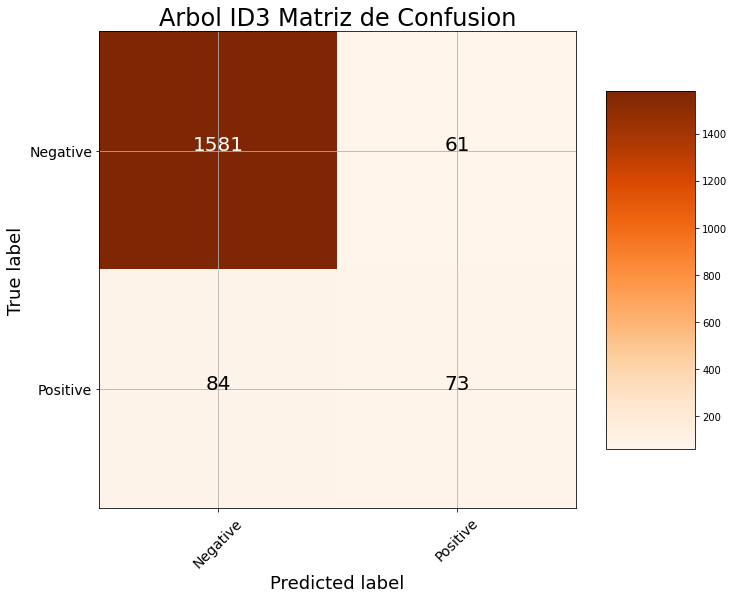

In [2]:
# Generar el arbol
n = len(X.index)
l = len(X.columns) - 1  # 1024
attrIdxPredecir = l
atributos = list(range(l))  # [0, 1, 2, .. 1023])
arbol= crearArbol(X, attrIdxPredecir, atributos)

# Realizar la prediccion
y_pred = predecir(arbol, X_test)        
    
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Negative', 'Positive'],
                      title = 'Arbol ID3 Matriz de Confusion')
print(classification_report(y_test, y_pred))


El random forest tiene tres hiperparámetros para determinar: la cantidad de ejemplos del dataset, la cantidad de árboles y la cantidad de atributos. Para seleccionarlos se optó por utilizar validación simple. Se separó el conjunto de entrenamiento nuevamente en conjuntos de entrenamiento y validación; donde se entrenan los random forest con distintos hiperparámetros seleccionados de un conjunto de posibles valores, en el conjunto de entrenamiento; se evalúa sobre el de verificación; y calculamos la medida-f para cada uno. Esta medida-f se usa como valor de performance para luego seleccionar los hiperparámetros que construyen al bosque con mejor valor.


In [3]:
# trabajamos solo con un subconjunto del conjunto de entrenamiento para que sea mas rapido
X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X, y_train, test_size=0.90, random_state=42)

scores = []
hyperparametros = [(0.5,100,30),(0.5,100,100),(0.2,100,100),(0.5,20,30),(0.2,20,300)] 
# Tuplas (proporcionMuestra, numArboles, numAtributos)


for hyperpar in hyperparametros:
    score = val_score_random_forest(X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper, hyperpar[0], hyperpar[1], hyperpar[2])
    scores.append(score)
    print(hyperpar, "    ", score)

i = np.argmax(score)

print('La mejor combinacion de hypers fue:', hyperparametros[i])


proporcionMuestra, numArboles, numAtributos = hyperparametros[i]


(0.5, 100, 30)      0.4808095290276726
(0.5, 100, 100)      0.5474228527134867
(0.2, 100, 100)      0.5493991809462226
(0.5, 20, 30)      0.49607094563405213
(0.2, 20, 300)      0.4920316641093597
La mejor combinacion de hypers fue: (0.5, 100, 30)


Generamos el random forest con los hiperparámetros seleccionados previamente.

Confusion matrix, without normalization
[[1642    0]
 [ 154    3]]
              precision    recall  f1-score   support

    negative       0.91      1.00      0.96      1642
    positive       1.00      0.02      0.04       157

    accuracy                           0.91      1799
   macro avg       0.96      0.51      0.50      1799
weighted avg       0.92      0.91      0.88      1799



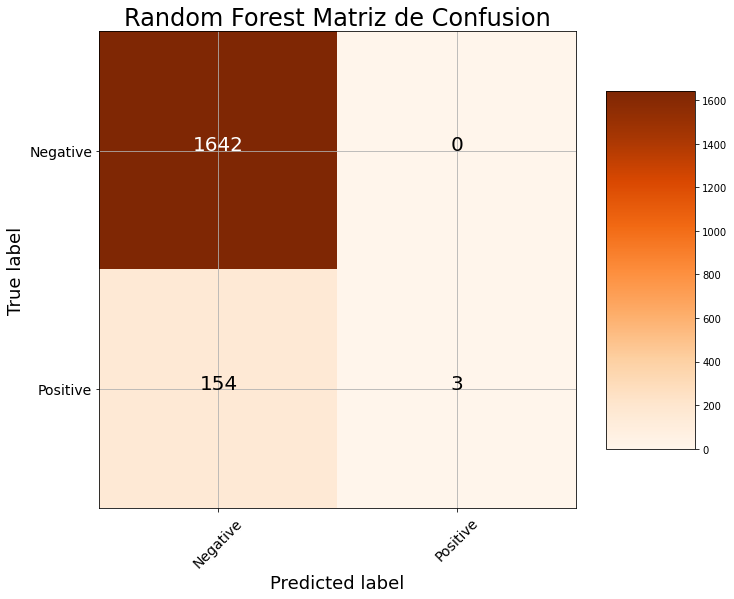

In [4]:
# Generar el bosque

arboles = rf.crearRandomForest_Wrapper(X, proporcionMuestra, numArboles, numAtributos, conPrints=True, numOfThreads=4)

y_pred = rf.predecirRandomForest(arboles, X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Negative', 'Positive'],
                      title = 'Random Forest Matriz de Confusion')
print(classification_report(y_test, y_pred))



A modo de comparación, se presentan los resultados de aplicar las implementaciones de scikit-learn para árboles de decisión y random forest sobre QSAR


Confusion matrix, without normalization
[[1537  105]
 [  78   79]]
              precision    recall  f1-score   support

    negative       0.95      0.94      0.94      1642
    positive       0.43      0.50      0.46       157

    accuracy                           0.90      1799
   macro avg       0.69      0.72      0.70      1799
weighted avg       0.91      0.90      0.90      1799



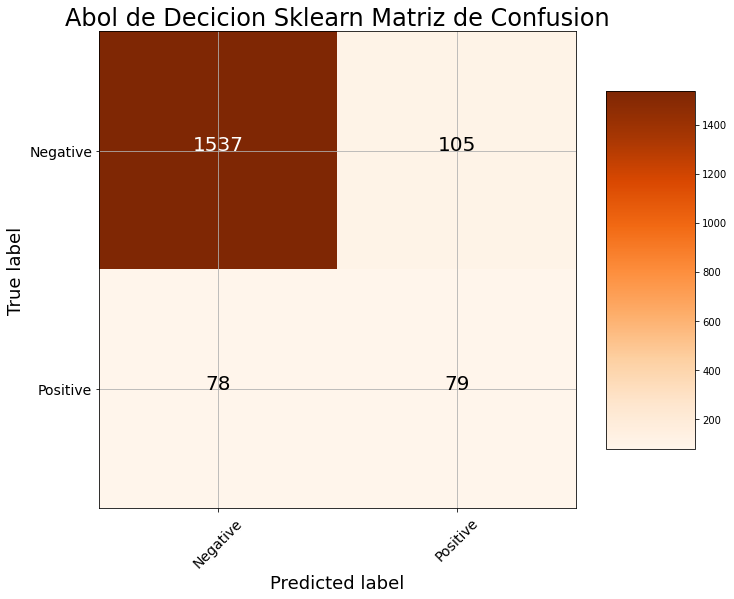

In [9]:
from sklearn.tree import DecisionTreeClassifier

X_train = X.drop(1024, axis=1)
X_test = X_test.drop(1024, axis=1)
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Negative', 'Positive'],
                      title = 'Abol de Decicion Sklearn Matriz de Confusion')
print(classification_report(y_test, y_pred))


Confusion matrix, without normalization
[[1621   21]
 [  94   63]]
              precision    recall  f1-score   support

    negative       0.95      0.99      0.97      1642
    positive       0.75      0.40      0.52       157

    accuracy                           0.94      1799
   macro avg       0.85      0.69      0.74      1799
weighted avg       0.93      0.94      0.93      1799



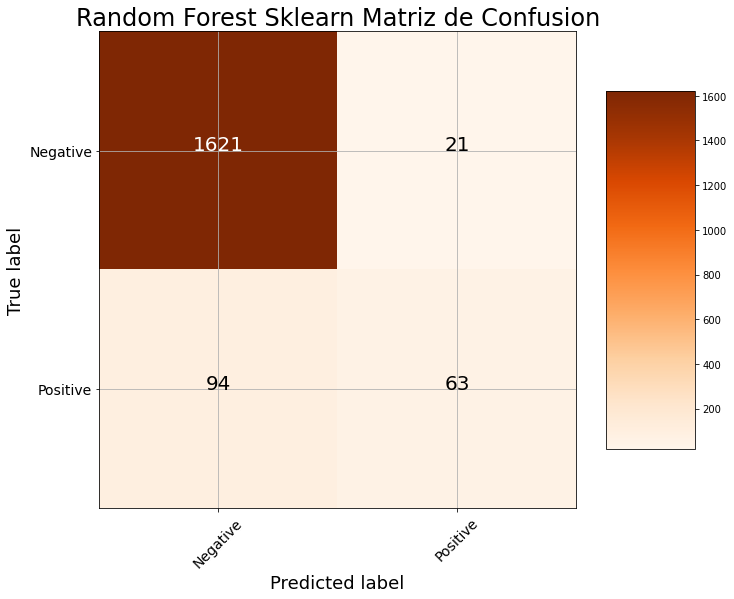

In [6]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Negative', 'Positive'],
                      title = 'Random Forest Sklearn Matriz de Confusion')
print(classification_report(y_test, y_pred))


![Valoracion de todas las columnas](img/Figure_1b.png "Title")
![Top 25 columnas mejor valoradas](img/Figure_2.png "Title")


## 4. Conclusión

Al correr nuestra implementación de ID3  se observa que obtiene muy buenas medidas de precisión, recuperación para la clase negative (cercanas al 0.96), y medidas muy malas para la clase positive (cercanas al 0.50). Es muy bueno clasificando a la clase con más ejemplos pero no lo es tanto con la otra.

Comparando los resultado con los obtenidos por el DecisionTreeClassifier de scikit learn se puede observar que ambos tienen resultados muy similares. Nuestra implementación obtuvo un acierto de 0.92, con medida-f de 0.73 contra un acierto de 0.90 y medida-f de 0.70 para la implementación de scikit learn. Una diferencia muy grande que sí hay entre las dos implementaciones está en el tiempo de ejecución, nuestro algoritmo tarda considerablemente más tiempo en ejecutarse que el de scikit learn.

Al correr la validación para ver qué hiperparámetros elegir para random forest, se puede observar que no parece haber una gran diferencia en los resultados obtenidos por los random forest con los diferentes conjuntos de hiperparámetros. En todos los casos se obtuvieron valores de medida-f comprendidos entre 0.48 y 0.55. Entre todos los probados, el que da mejores resultados es el que usa un 50% de los ejemplos, 100 árboles y 100 atributos. Los casos en los que varía solamente la proporción de la muestra, o sólo la cantidad de árboles, no varía mucho el resultado.  Se ve un aumento del valor obtenido entre cuando tienen los mismos otros hiperparametros y solo aumenta la cantidad de árboles.

Sobre los resultados obtenidos por nuestra implementación de random forest se puede observar que clasifica muy bien a los ejemplos negativos y muy mal a los ejemplos positivos. A los elementos de la clase minoritaria los clasifica a casi todos incorrectamente, lo que lleva a que tenga un muy bajo valor de recuperación y por lo tanto también medida-f. De todas formas, tiene un acierto del 0.91 que es bastante elevado, debido a que clasifica a los elementos de la clase mayoritaria correctamente. Para este caso la medida del acierto no es un buen indicador de que tan bien se desempeña el algoritmo.

Comparando con los resultados obtenidos por el RandomForestClassifier de scikit learn, nuestra implementación obtiene resultados mucho peores. Los resultados obtenidos por el algoritmo de scikit learn son cercanos a los de árboles de decisión, con 0.94 de acierto y 0.74 de medida-f.

Comparando los resultados de RandomForestClassifier contra los de DecisionTreeClassifier se puede observar que el random forest obtiene un mayor acierto y medida-f; pero no es tan bueno identificando a los ejemplos positivos, lo que se observa en un mayor recall.

Comprando el Random Forest y ID3 implementado se puede observar que el Random Forest tiene mejor precisión  en los casos positivos que el ID3, pero en la mayoría de los casos que identificó como positivos resultaron ser negativos, dando una recuperación muy baja. Sin embargo con el algoritmo ID3 se obtiene una precisión más chica de casos positivos pero la precisión de estos casos es mucho mejor, identificando un 54% como falso positivo. No es una figura muy buena pero es mejor  que identificar el 98% como falso positivo. En los casos negativos Random Forest obtiene mejor resultado, no identifica ningún caso como falso negativo  mientras que el algoritmo ID3 identifica un 4%.
En general se puede observar que los algoritmos son buenos para identificar casos negativos pero en el momento de reconocer casos positivos, el clasificador ID3 tuvo mejores resultados. Esto puede darse por el desbalance de los datos pero si la idea era identificar casos positivos con certeza, hace falta más datos que den como resultado valores positivo. 
Durante la implementación del código y análisis de los datos de esta tarea nos topamos con varias posibilidades de mejorar la calidad del código y los datos que se utilizaron que al final no fueron descartadas. Existió la posibilidad de estratificar los datos dado que estos eran mayormente resultados negativos. Esto llevaría resultados diferente ya que los árboles de decisiones serían distintos.
También existe la posibilidad de probar con más variaciones en los hiperparámetros para obtener un mejor resultado en el Random Forest. Si bien esto era una posibilidad, dado el alto costo computacional se optó por seleccionar algunos posibles valores que dieron buen resultado mientras que testeamos el código. En el júpiter se intentó dar una idea de la evolución del Random Forest obtenido.
Una de las razones por la que el tiempo de cómputo es alto, es por la implementación del código que utilizamos. Al principio se inició con una idea de generar un algoritmo lo más general posible que sin importar los posibles valores que pueden tomar los atributos, se generaría un árbol con en algoritmo ID3. En el momento empezar a analizar los datos y correr el código, nos dimos cuenta que demoraba mucho en realizar algunos cálculos y empezamos a optimizar y ajustar el código a los datos que teníamos. Algunas partes mejorar y otras partes quedaron por mejorase.
